In [1]:
import os, sys, random, json, platform, math, shutil
from pathlib import Path
import numpy as np
import torch, torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(json.dumps({
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "torch": torch.__version__,
    "torchvision": torchvision.__version__,
    "cuda_available": torch.cuda.is_available(),
    "device": str(DEVICE),
    "gpu_name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else None
}, indent=2))

{
  "python": "3.10.16",
  "platform": "Linux-5.4.0-222-generic-x86_64-with-glibc2.31",
  "torch": "2.6.0+cu124",
  "torchvision": "0.21.0+cu124",
  "cuda_available": true,
  "device": "cuda",
  "gpu_name": "NVIDIA GeForce GTX 1080 Ti"
}


In [2]:
from pathlib import Path

# Point BASE_DIR to your folder
BASE_DIR = Path("/data1/Sadia/Dr_Alam_Course_applied_AI/dogs_cats_classifier/dogs-vs-cats").resolve()

DATA_ROOT = BASE_DIR                        # no nested "data" folder
KAGGLE_TRAIN_DIR = DATA_ROOT / "train"      # your train folder with cat/dog images

SPLITS_DIR  = BASE_DIR / "splits"
MODELS_DIR  = BASE_DIR / "models"
FIG_DIR     = BASE_DIR / "figures"
RUNS_DIR    = BASE_DIR / "runs"
METRICS_DIR = BASE_DIR / "metrics"
SR_DATA_DIR = BASE_DIR / "data_sr"

for d in [SPLITS_DIR, MODELS_DIR, FIG_DIR, RUNS_DIR, METRICS_DIR, SR_DATA_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("KAGGLE_TRAIN_DIR:", KAGGLE_TRAIN_DIR)

BASE_DIR: /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_cats_classifier/dogs-vs-cats
KAGGLE_TRAIN_DIR: /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_cats_classifier/dogs-vs-cats/train


In [3]:
import re
import pandas as pd
from sklearn.model_selection import train_test_split

assert KAGGLE_TRAIN_DIR.exists(), f"Missing {KAGGLE_TRAIN_DIR}. Put Kaggle train images here."

paths, labels = [], []
for p in sorted(KAGGLE_TRAIN_DIR.glob("*.jpg")):
    name = p.name.lower()
    if name.startswith("cat"):
        paths.append(str(p)); labels.append(0)
    elif name.startswith("dog"):
        paths.append(str(p)); labels.append(1)

df = pd.DataFrame({"path": paths, "label": labels})
print("Found images:", len(df), " | class counts:", df["label"].value_counts().to_dict())

# 70/30 stratified split
train_df, test_df = train_test_split(
    df, test_size=0.30, random_state=42, shuffle=True, stratify=df["label"]
)

train_csv = SPLITS_DIR / "train70.csv"
test_csv  = SPLITS_DIR / "test30.csv"
train_df.to_csv(train_csv, index=False)
test_df.to_csv(test_csv, index=False)

print("Saved:", train_csv, "|", test_csv)
train_df.head(), test_df.head()

Found images: 25000  | class counts: {0: 12500, 1: 12500}
Saved: /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_cats_classifier/dogs-vs-cats/splits/train70.csv | /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_cats_classifier/dogs-vs-cats/splits/test30.csv


(                                                    path  label
 24393  /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_ca...      1
 10884  /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_ca...      0
 16419  /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_ca...      1
 6596   /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_ca...      0
 12718  /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_ca...      1,
                                                     path  label
 15245  /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_ca...      1
 16097  /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_ca...      1
 16848  /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_ca...      1
 2491   /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_ca...      0
 12801  /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_ca...      1)

In [4]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader

IMSIZE = 128
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.10, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_tfms = transforms.Compose([
    transforms.Resize((IMSIZE, IMSIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class ImageCSVDataset(Dataset):
    def __init__(self, csv_file, transform):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        x = self.transform(img)
        y = int(row["label"])
        return x, y, row["path"]

train_set = ImageCSVDataset(train_csv, transform=train_tfms)
test_set  = ImageCSVDataset(test_csv,  transform=test_tfms)

BATCH_SIZE = 64
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

len(train_set), len(test_set)

(17500, 7500)

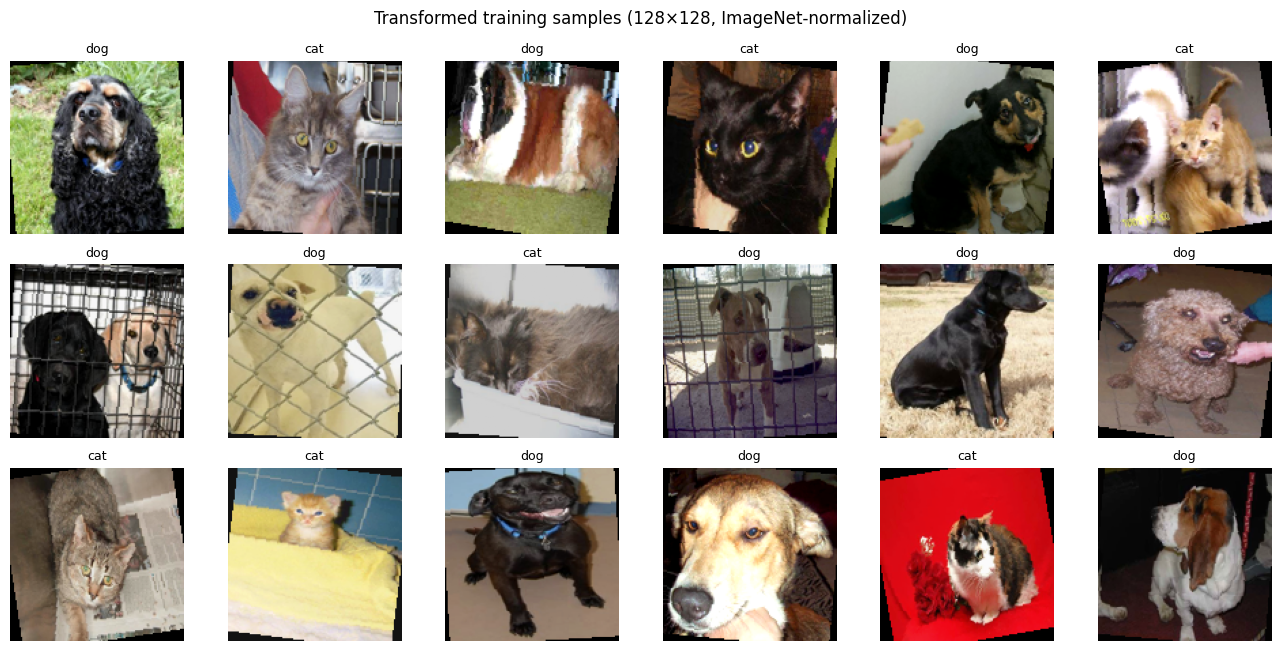

In [5]:
# Show a batch of transformed samples (denormalize for display)
def denorm(t):
    mean = torch.tensor(IMAGENET_MEAN).view(3,1,1)
    std  = torch.tensor(IMAGENET_STD).view(3,1,1)
    return (t * std + mean).clamp(0,1)

imgs, labels, _ = next(iter(train_loader))
grid_cols, grid_rows = 6, 3
n = min(grid_cols*grid_rows, imgs.size(0))

plt.figure(figsize=(grid_cols*2.2, grid_rows*2.2))
for i in range(n):
    plt.subplot(grid_rows, grid_cols, i+1)
    plt.imshow(denorm(imgs[i]).permute(1,2,0).cpu().numpy())
    plt.title("dog" if labels[i].item()==1 else "cat", fontsize=9)
    plt.axis("off")
plt.suptitle("Transformed training samples (128×128, ImageNet-normalized)", y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
import torch.nn as nn
import torchvision.models as models
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

BACKBONE = "resnet18"  # options: "resnet18", "vgg16", "mobilenet_v2"

def build_model(backbone=BACKBONE, pretrained=True):
    if backbone == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        in_feat = m.fc.in_features
        m.fc = nn.Linear(in_feat, 1)
    elif backbone == "vgg16":
        m = models.vgg16(weights=models.VGG16_Weights.DEFAULT if pretrained else None)
        in_feat = m.classifier[-1].in_features
        m.classifier[-1] = nn.Linear(in_feat, 1)
    elif backbone == "mobilenet_v2":
        m = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT if pretrained else None)
        in_feat = m.classifier[-1].in_features
        m.classifier[-1] = nn.Linear(in_feat, 1)
    else:
        raise ValueError("Unknown backbone")
    return m

modelA = build_model().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW([p for p in modelA.parameters() if p.requires_grad], lr=1e-3, weight_decay=1e-4)

In [6]:
import torch.nn as nn
import torchvision.models as models
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

BACKBONE = "resnet18"  # options: "resnet18", "vgg16", "mobilenet_v2"

def build_model(backbone=BACKBONE, pretrained=True):
    if backbone == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        in_feat = m.fc.in_features
        m.fc = nn.Linear(in_feat, 1)
    elif backbone == "vgg16":
        m = models.vgg16(weights=models.VGG16_Weights.DEFAULT if pretrained else None)
        in_feat = m.classifier[-1].in_features
        m.classifier[-1] = nn.Linear(in_feat, 1)
    elif backbone == "mobilenet_v2":
        m = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT if pretrained else None)
        in_feat = m.classifier[-1].in_features
        m.classifier[-1] = nn.Linear(in_feat, 1)
    else:
        raise ValueError("Unknown backbone")
    return m

modelA = build_model().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW([p for p in modelA.parameters() if p.requires_grad], lr=1e-3, weight_decay=1e-4)
# Freeze all but classifier head
for p in modelA.parameters():
    p.requires_grad = False
# Unfreeze head
if hasattr(modelA, "fc"):
    for p in modelA.fc.parameters(): p.requires_grad = True
elif hasattr(modelA, "classifier"):
    for p in modelA.classifier.parameters(): p.requires_grad = True

optimizer = AdamW([p for p in modelA.parameters() if p.requires_grad], lr=1e-3, weight_decay=1e-4)

EPOCHS_WARMUP = 3
for epoch in range(EPOCHS_WARMUP):
    modelA.train()
    losses=[]
    for x,y,_ in tqdm(train_loader, desc=f"Warmup {epoch+1}/{EPOCHS_WARMUP}"):
        x,y = x.to(DEVICE), y.float().to(DEVICE)
        optimizer.zero_grad()
        logits = modelA(x).squeeze(1)
        loss = criterion(logits, y)
        loss.backward(); optimizer.step()
        losses.append(loss.item())
    print("Warmup loss:", np.mean(losses))
# Unfreeze all for full fine-tune (or selectively unfreeze last blocks if desired)
for p in modelA.parameters(): p.requires_grad = True
optimizer = AdamW(modelA.parameters(), lr=1e-4, weight_decay=1e-4)

def evaluate(model, loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for x,y,_ in loader:
            x = x.to(DEVICE); y = y.numpy()
            logits = model(x).squeeze(1)
            prob = torch.sigmoid(logits).cpu().numpy()
            ys.extend(list(y)); ps.extend(list(prob))
    ys = np.array(ys); ps = np.array(ps)
    preds = (ps>=0.5).astype(int)
    return {
        "acc": accuracy_score(ys, preds),
        "f1": f1_score(ys, preds),
        "auc": roc_auc_score(ys, ps),
    }

EPOCHS_FT = 12
best_auc, best_path = -1, MODELS_DIR / "modelA_best.pt"
for epoch in range(EPOCHS_FT):
    modelA.train()
    for x,y,_ in tqdm(train_loader, desc=f"FT {epoch+1}/{EPOCHS_FT}"):
        x,y = x.to(DEVICE), y.float().to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(modelA(x).squeeze(1), y)
        loss.backward(); optimizer.step()
    # quick eval on test30 (you may optionally carve a val split from the 70% train to avoid touching test—up to you)
    scores = evaluate(modelA, test_loader)
    print(f"Epoch {epoch+1}: ", scores)
    if scores["auc"] > best_auc:
        best_auc = scores["auc"]
        torch.save(modelA.state_dict(), best_path)
        print("↑ Saved:", best_path, "AUC:", best_auc)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /run/user/1813260370/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s] 
Warmup 1/3: 100%|██████████| 274/274 [00:29<00:00,  9.39it/s]


Warmup loss: 0.3137582178859815


Warmup 2/3: 100%|██████████| 274/274 [00:29<00:00,  9.34it/s]


Warmup loss: 0.23904336483156594


Warmup 3/3: 100%|██████████| 274/274 [00:29<00:00,  9.43it/s]


Warmup loss: 0.21861830522326658


FT 1/12: 100%|██████████| 274/274 [00:29<00:00,  9.20it/s]


Epoch 1:  {'acc': 0.9653333333333334, 'f1': 0.9646643109540636, 'auc': np.float64(0.9965141688888889)}
↑ Saved: /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_cats_classifier/dogs-vs-cats/models/modelA_best.pt AUC: 0.9965141688888889


FT 2/12: 100%|██████████| 274/274 [00:29<00:00,  9.29it/s]


Epoch 2:  {'acc': 0.9714666666666667, 'f1': 0.9712597367714209, 'auc': np.float64(0.9971955911111111)}
↑ Saved: /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_cats_classifier/dogs-vs-cats/models/modelA_best.pt AUC: 0.9971955911111111


FT 3/12: 100%|██████████| 274/274 [00:29<00:00,  9.32it/s]


Epoch 3:  {'acc': 0.9730666666666666, 'f1': 0.9728348574502421, 'auc': np.float64(0.9970808888888888)}


FT 4/12: 100%|██████████| 274/274 [00:29<00:00,  9.35it/s]


Epoch 4:  {'acc': 0.9713333333333334, 'f1': 0.9710359692846559, 'auc': np.float64(0.9968104533333334)}


FT 5/12: 100%|██████████| 274/274 [00:29<00:00,  9.39it/s]


Epoch 5:  {'acc': 0.9750666666666666, 'f1': 0.9750699906679109, 'auc': np.float64(0.9977651911111112)}
↑ Saved: /data1/Sadia/Dr_Alam_Course_applied_AI/dogs_cats_classifier/dogs-vs-cats/models/modelA_best.pt AUC: 0.9977651911111112


FT 6/12: 100%|██████████| 274/274 [00:29<00:00,  9.41it/s]


Epoch 6:  {'acc': 0.9729333333333333, 'f1': 0.9731090210623924, 'auc': np.float64(0.9972847999999999)}


FT 7/12: 100%|██████████| 274/274 [00:29<00:00,  9.20it/s]


Epoch 7:  {'acc': 0.9778666666666667, 'f1': 0.9776821726270503, 'auc': np.float64(0.9976473600000001)}


FT 8/12: 100%|██████████| 274/274 [00:31<00:00,  8.83it/s]


Epoch 8:  {'acc': 0.9752, 'f1': 0.9750335570469799, 'auc': np.float64(0.9976824177777778)}


FT 9/12: 100%|██████████| 274/274 [00:30<00:00,  9.10it/s]


Epoch 9:  {'acc': 0.9746666666666667, 'f1': 0.9744211093161013, 'auc': np.float64(0.9976998755555555)}


FT 10/12: 100%|██████████| 274/274 [00:29<00:00,  9.35it/s]


Epoch 10:  {'acc': 0.9746666666666667, 'f1': 0.9747474747474747, 'auc': np.float64(0.9974569244444444)}


FT 11/12: 100%|██████████| 274/274 [00:29<00:00,  9.36it/s]


Epoch 11:  {'acc': 0.9766666666666667, 'f1': 0.9766199064796259, 'auc': np.float64(0.9974941155555557)}


FT 12/12: 100%|██████████| 274/274 [00:29<00:00,  9.35it/s]


Epoch 12:  {'acc': 0.9776, 'f1': 0.977552111170497, 'auc': np.float64(0.9977479466666667)}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.007636838..1.0436053].


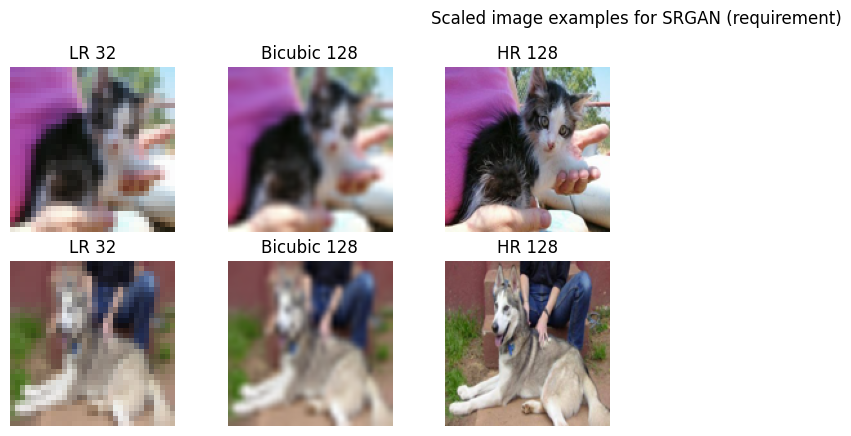

In [11]:
# Helpers to make HR(128), LR(32), and to visualize a few samples
from torchvision.transforms.functional import resize

hr_tfms = transforms.Compose([
    transforms.Resize((128,128), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
])

# no normalize here; GANs commonly work in [0,1] or [-1,1]
# we'll keep [0,1] and let the Generator output tanh or sigmoid later
class SRPairDataset(Dataset):
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        p = self.df.iloc[idx]["path"]
        img = Image.open(p).convert("RGB")
        hr = hr_tfms(img)                          # (3,128,128) in [0,1]
        lr_small = resize(hr, [32,32], antialias=True) # (3,32,32)
        return lr_small, hr, p

sr_train = SRPairDataset(train_csv)
sr_loader = DataLoader(sr_train, batch_size=8, shuffle=True, num_workers=4)

# Visual sanity-check: LR 32, bicubic-upsampled 128, HR 128
lr, hr, paths = next(iter(sr_loader))
up = torch.nn.functional.interpolate(lr, size=(128,128), mode="bicubic", align_corners=False)

cols = 6
rows = min(2, lr.size(0))
plt.figure(figsize=(cols*2.2, rows*2.2))
for i in range(rows):
    # LR 32 (nearest display)
    plt.subplot(rows, cols, i*cols+1); plt.imshow(lr[i].permute(1,2,0)); plt.title("LR 32"); plt.axis("off")
    # LR→bicubic 128
    plt.subplot(rows, cols, i*cols+2); plt.imshow(up[i].permute(1,2,0)); plt.title("Bicubic 128"); plt.axis("off")
    # HR 128
    plt.subplot(rows, cols, i*cols+3); plt.imshow(hr[i].permute(1,2,0)); plt.title("HR 128"); plt.axis("off")
plt.suptitle("Scaled image examples for SRGAN (requirement)")
plt.tight_layout(); plt.show()

In [ ]:
# Minimal SRGAN modules (concise, solid baseline)
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, nf=64):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(64,64,3,1,1), nn.BatchNorm2d(64), nn.PReLU(),
            nn.Conv2d(64,64,3,1,1), nn.BatchNorm2d(64),
        )
    def forward(self, x): return x + self.block(x)

class GeneratorSR(nn.Module):
    def __init__(self, n_blocks=4, upscale=4):
        super().__init__()
        self.head = nn.Sequential(nn.Conv2d(3,64,9,1,4), nn.PReLU())
        self.body = nn.Sequential(*[ResidualBlock(64) for _ in range(n_blocks)])
        self.tail = nn.Sequential(
            nn.Conv2d(64,64,3,1,1),
            nn.BatchNorm2d(64),
            # two pixel-shuffle x2 to reach x4 total
            nn.Conv2d(64,256,3,1,1), nn.PixelShuffle(2), nn.PReLU(),
            nn.Conv2d(64,256,3,1,1), nn.PixelShuffle(2), nn.PReLU(),
            nn.Conv2d(64,3,9,1,4),
            nn.Sigmoid(),  # output in [0,1]
        )
    def forward(self, x):
        x1 = self.head(x)
        x2 = self.body(x1)
        return self.tail(x1 + x2)

class DiscriminatorSR(nn.Module):
    def __init__(self):
        super().__init__()
        def block(in_c,out_c,ks=3,stride=1):
            return nn.Sequential(
                nn.Conv2d(in_c,out_c,ks,stride,1), nn.BatchNorm2d(out_c), nn.LeakyReLU(0.2, inplace=True)
            )
        self.net = nn.Sequential(
            block(3,64,3,1), block(64,64,3,2),
            block(64,128,3,1), block(128,128,3,2),
            block(128,256,3,1), block(256,256,3,2),
            block(256,512,3,1), block(512,512,3,2),
            nn.Flatten(),
            nn.Linear(512*8*8, 1024), nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024,1)
        )
    def forward(self, x): return self.net(x)
from torchvision.models import vgg19, VGG19_Weights

class VGGFeature(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg19(weights=VGG19_Weights.DEFAULT).features
        # conv5_4 or conv3_4 are common; we’ll use conv5_4-ish depth
        self.slice = nn.Sequential(*list(vgg.children())[:36]).eval()
        for p in self.slice.parameters(): p.requires_grad=False
    def forward(self, x): return self.slice(x)

def to_vgg_range(x):
    # x in [0,1] -> normalize by ImageNet mean/std for VGG
    mean = torch.tensor(IMAGENET_MEAN).view(1,3,1,1).to(x.device)
    std = torch.tensor(IMAGENET_STD).view(1,3,1,1).to(x.device)
    return (x - mean) / std
from torch.optim import Adam
from math import log10

G = GeneratorSR().to(DEVICE)
D = DiscriminatorSR().to(DEVICE)
vgg_feat = VGGFeature().to(DEVICE)

pix_loss = nn.MSELoss()
bce_logits = nn.BCEWithLogitsLoss()
optG = Adam(G.parameters(), lr=1e-4, betas=(0.9, 0.999))
optD = Adam(D.parameters(), lr=1e-4, betas=(0.9, 0.999))

def psnr(pred, target):
    mse = torch.mean((pred - target) ** 2).item()
    if mse == 0: return 99.0
    return 10 * log10(1.0 / mse)

# Pretrain Generator (5–10 epochs)
PRE_EPOCHS = 5
for ep in range(PRE_EPOCHS):
    G.train(); losses=[]
    for lr, hr, _ in tqdm(sr_loader, desc=f"PreG {ep+1}/{PRE_EPOCHS}"):
        lr, hr = lr.to(DEVICE), hr.to(DEVICE)
        sr = G(lr)
        loss = pix_loss(sr, hr)
        optG.zero_grad(); loss.backward(); optG.step()
        losses.append(loss.item())
    print("Pretrain G pixel loss:", np.mean(losses))

# Adversarial training (≥150 epochs)
EPOCHS_GAN = 150
lambda_adv = 1e-3
for ep in range(EPOCHS_GAN):
    G.train(); D.train()
    g_losses, d_losses, psnrs = [], [], []
    for lr, hr, _ in tqdm(sr_loader, desc=f"GAN {ep+1}/{EPOCHS_GAN}"):
        lr, hr = lr.to(DEVICE), hr.to(DEVICE)

        # ---- Train D ----
        with torch.no_grad():
            sr = G(lr)
        real_logits = D(hr)
        fake_logits = D(sr)
        d_loss = bce_logits(real_logits, torch.ones_like(real_logits)) + \
                 bce_logits(fake_logits, torch.zeros_like(fake_logits))
        optD.zero_grad(); d_loss.backward(); optD.step()

        # ---- Train G ----
        sr = G(lr)
        fake_logits = D(sr)
        content = pix_loss(sr, hr) + 0.006 * F.mse_loss(vgg_feat(to_vgg_range(sr)), vgg_feat(to_vgg_range(hr)))
        adv = bce_logits(fake_logits, torch.ones_like(fake_logits))
        g_loss = content + lambda_adv * adv
        optG.zero_grad(); g_loss.backward(); optG.step()

        g_losses.append(g_loss.item()); d_losses.append(d_loss.item()); psnrs.append(psnr(sr.detach(), hr))

    print(f"Epoch {ep+1}: G={np.mean(g_losses):.4f} D={np.mean(d_losses):.4f} PSNR~{np.mean(psnrs):.2f}")
    # save best G by PSNR if desired
    torch.save(G.state_dict(), MODELS_DIR / f"srganG_ep{ep+1}.pt")